# ESE-2000 Lab 6
TO DO add intro

We download a ~1MB file containing the entirety of Shakespeare's work. This is the dataset we will train our language model on.

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-10-18 09:13:17--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.5’

input.txt.5         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-10-18 09:13:18 (18.5 MB/s) - ‘input.txt.5’ saved [1115394/1115394]



In [3]:
import torch
from tqdm import trange
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from IPython.core.display_functions import clear_output
import matplotlib.pyplot as plt
import math
#import wandb
import re
device = "cpu"
if torch.backends.mps.is_available():
    device = "mps:0"
elif torch.cuda.is_available():
    device = "cuda:0"
#wandb.login()
#run = wandb.init(
#    project="lab-9-llm",
#    config={
#        "architecture": "Transformer",
#        "dataset": "TinyShakespeare"
#    }
#)

### Data

###  Data Loading

In [4]:
with open('input.txt') as f:
    text = f.read()
    

print("----Sample Shakespeare----")
print(text[:250])

----Sample Shakespeare----
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## Tokenization

Tokenization converts raw sub-sequences of text (substrings) to sequences of integers. For example, `"ll." -> 208`. We will be developing a character level language model, so we will be converting each individual word into an integer. For example, `"Hello" -> 48`.

In [5]:
def split_to_words(text):
    return re.findall(r"\w+(?:'\w+)?|[.,!?;:\"()\[\]{}<>\\/\-—–…]|\n", text)

vocab = list(set(split_to_words(text)))
vocab_size = len(vocab)
print("Number of words: {}".format(len(split_to_words(text))))
print("Number of distinct words in text: {}".format(vocab_size))

Number of words: 292072
Number of distinct words in text: 14295


In [6]:
# Use index to map words to integer
stoi = {word:i for i, word in enumerate(vocab)}
itos = {i:word for i, word in enumerate(vocab)}
def words_to_tokens(words):
    return [stoi[w] for w in words]

def tokens_to_words(int_list):
    decoded = " ".join([itos[i] for i in int_list])
    return re.sub(r'\s+([.,!?;:"(){}\[\]<>\\/\-—–…])', r'\1', decoded)

sample_words = text[:36]
print("Original text: {}\n".format(sample_words))
print("Encoded text: {}\n".format(words_to_tokens(split_to_words(sample_words))))
print("Decoded text: {}\n".format(tokens_to_words(words_to_tokens(split_to_words(sample_words)))))

Original text: First Citizen:
Before we proceed any

Encoded text: [2730, 5395, 4741, 12170, 11475, 10322, 11670, 2478]

Decoded text: First Citizen: 
 Before we proceed any



In [7]:
tokenized_text = words_to_tokens(split_to_words(text))
print("Encoded text sample: {}".format(tokenized_text[:10]))
print(tokens_to_words(tokenized_text[:10]))
tokenized_text = torch.tensor(tokenized_text)

Encoded text sample: [2730, 5395, 4741, 12170, 11475, 10322, 11670, 2478, 13940, 13253]
First Citizen: 
 Before we proceed any further,


### Data Split

In [8]:
context_size = 64
split_factor = 0.9
split_index = int(split_factor * len(tokenized_text))
train = tokenized_text[:split_index].to(device)
test = tokenized_text[split_index:].to(device)

### Data Loader

In [47]:
class TextDataset(Dataset):
    def __init__(self, text, context_size):
        self.text = text
        self.context_size = context_size
        assert self.context_size < len(text), "context_size must be less than len(text)"

    def __len__(self):
        return len(self.text) - self.context_size

    def __getitem__(self, idx):
        return self.text[idx:idx + self.context_size],  self.text[idx + 1:idx + self.context_size + 1]

train_set = TextDataset(train, context_size)
test_set = TextDataset(test, context_size)
batch_size = 300
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## Co-occurrence matrix

In [48]:
# Create co-occurrence matrix
# The co-occurrence matrix X is a VxV (V is our vocab size) symmetric matrix where X_ij is how many times the ith word appears within W words away from the jth word.
W = 10
X = torch.stack([torch.zeros(len(vocab)) for _ in range(len(vocab))])
for t_idx in trange(len(tokenized_text)):
    left_bound = max(t_idx-W//2,0)
    right_bound = min(t_idx+W//2+1,len(tokenized_text))
    context_words = tokenized_text[left_bound : right_bound]
    for u_idx in range(left_bound, right_bound):
        t = tokenized_text[t_idx]
        u = tokenized_text[u_idx]
        X[t, u] += 1.0
X = X.to(device)
# X should be a symmetric matrix
torch.isclose(X, X.T, atol=1e-3).all()

100%|██████████| 292072/292072 [00:47<00:00, 6188.72it/s]


tensor(True, device='cuda:0')

In [49]:
torch.isclose(X, X.T, atol=1e-3).all()

tensor(True, device='cuda:0')

## PCA Embeddings

In [50]:
# Torch has a bug on mps devices so this won't work on MacBooks
embedding_dim = 256
Z = X - X.mean(dim=0, keepdim=True)
Z /= Z.std(dim=0, keepdim=True)
cov = (Z @ Z.T)/(Z.shape[0] - 1)
L, Q = torch.linalg.eigh(cov)
principal_eigv = Q[:, -embedding_dim:].T

# PCA embeddings for training
embeddings = Z @ principal_eigv.T # (vocab_size, embedding_dim)
# Full embeddings if we need them to visualize
# In vector form would be Q.T @ x_n
full_embeddings = Z @ Q

# Visualize embeddings
Decide if this section goes into the notebook or not

## Average coefficients


In [62]:
average_coefficients.shape#.norm(p=2,dim=0).shape

torch.Size([14295])

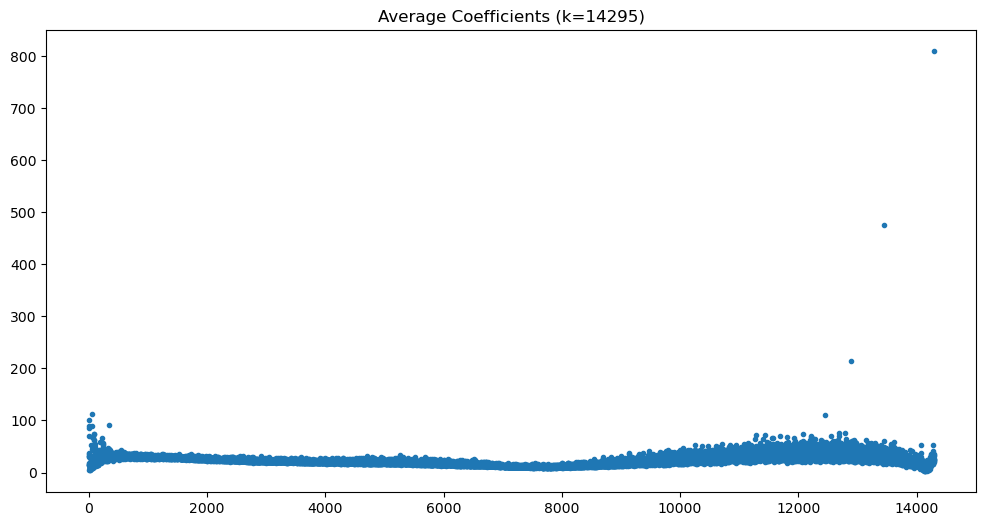

In [95]:
K=14295
#average_coefficients = full_embeddings.mean(axis=0)
sample_embeddings = full_embeddings[torch.randint(0,full_embeddings.shape[0],(1000,))]
# Compute the expectation of the absolute value of the norm of each component.
average_coefficients = sample_embeddings.norm(p=2,dim=0).cpu().numpy()[::-1]
data = average_coefficients[:K]

# Reverse the tensor:
data = data

# Normalize by sum?
#data = data / data.sum()

plt.figure(figsize=(12, 6))
plt.title(f"Average Coefficients (k={K})")
fig= plt.plot(range(K), data,marker='.',linestyle='')


plt.show()

## Principal eigenvalues

[None, None]

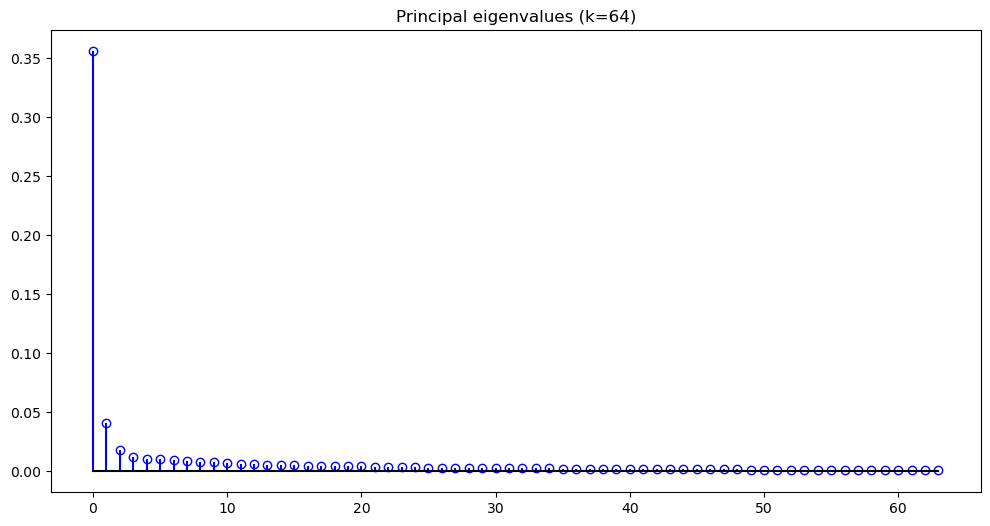

In [220]:
K=64
L_plot = L[-K:]/L.sum()
L_plot,_ = L_plot.sort(descending=True)
L_plot = L_plot.cpu().numpy()
plt.figure(figsize=(12, 6))
plt.title("Principal eigenvalues (k=64)")
markerline, stemlines, baseline = plt.stem(range(K), L_plot, linefmt='b-', markerfmt='o', basefmt='k-')
plt.setp(markerline, marker='o', fillstyle='none')


## Co ocurrence matrix

In [35]:
# Top 10 words
top_10_words = X.sum(axis=0).sort(descending=True).indices[:10]
top_10_words = [vocab[i] for i in top_10_words]
print(top_10_words)

['\n', ',', ':', '.', 'the', 'I', 'to', 'and', ';', 'of']


"Top 100 words, excluding punctation and most common stop words: \n he him shall no That on what But good O from What more at if now sir them For was would KING lord their am they My I'll then here she or love us come say well As hath one A make may man were like than know must king You upon should an"

/tmp/ipykernel_2520948/3128692209.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


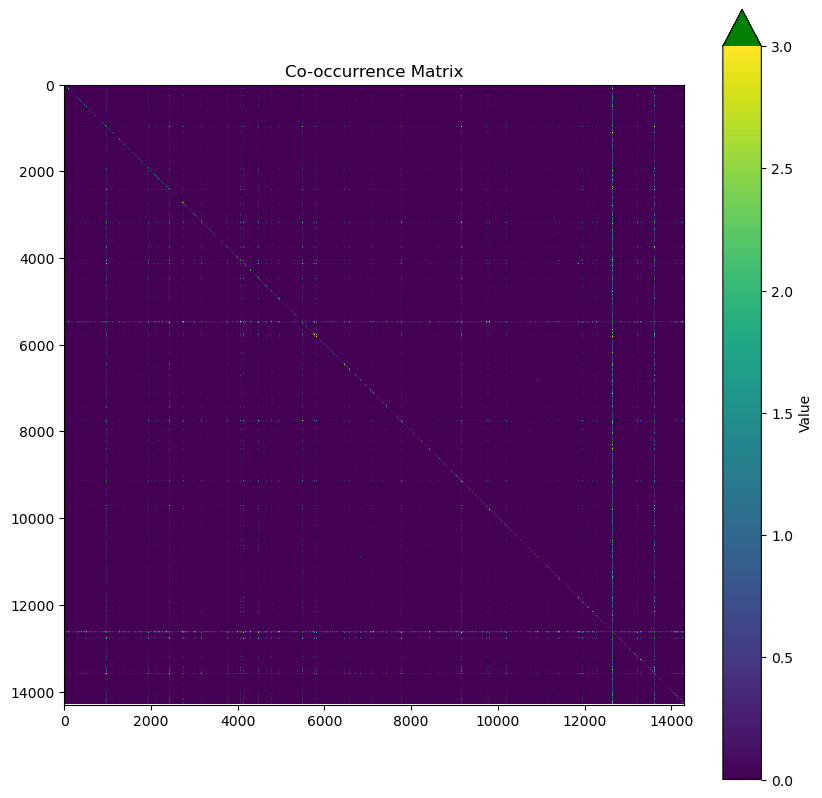

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Remove all the punctations and stop words from the matrix for visualization
X_viz = X.clone()
words_to_remove = [",", ":", ".", "the", "I", "to", "and", ";", "of", "you", "my", "a", "?", "!", "in", "that", "And", "not", "-", "is", "me", "be", "it", "with", "your", "for", "his", "have", "this", "thou", "as", "thy", "will", "so", "but", "The", "To", "all", "her", "thee", "by", "are", "our", "do", "we"]
vocab_to_remove_indices = set(words_to_tokens(words_to_remove))
idx_to_viz = [i for i, word in enumerate(vocab) if word not in vocab_to_remove_indices]
X_viz = X_viz[idx_to_viz, :][:, idx_to_viz]

# top 20 words not including stop words
top_100_words = X.sum(axis=0).sort(descending=True).indices[:100].cpu().numpy()
top_100_nostop = [word for word in top_100_words if word not in vocab_to_remove_indices]
display(f"Top 100 words, excluding punctation and most common stop words: {tokens_to_words(top_100_nostop)}")

# Create a custom colormap
cmap = plt.cm.get_cmap('viridis').copy()
cmap.set_over('green')

# Plot the image with the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(X_viz.cpu().numpy(), cmap=cmap, vmax=3)

# Add colorbar with custom settings
cbar = plt.colorbar(extend='max')
cbar.set_label('Value')

plt.title('Co-occurrence Matrix')
plt.show()
# Model

# Model

In [19]:
class HeadAttn(nn.Module):
    def __init__(self, D):
        super(HeadAttn, self).__init__()
        self.D = D
        self.Wq = nn.Linear(embedding_dim, self.D, bias=False)
        self.Wk = nn.Linear(embedding_dim, self.D, bias=False)
        self.Wv = nn.Linear(embedding_dim, self.D, bias=False)
    def forward(self, x, use_mask=True):

        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x) 
        
        qk =  q @ k.transpose(-2, -1) * (self.D ** -0.5) 

        if use_mask:
            mask = torch.tril_indices(qk.shape[-2], qk.shape[-1], -1)
            qk[:, mask[0], mask[1]] = float('-inf')

        softmax_qk = F.softmax(qk, dim=-1)
        qkv = softmax_qk @ v
        return qkv
    
class MultiHeadAttn(nn.Module):
    def __init__(self, num_heads, D):
        super(MultiHeadAttn, self).__init__()
        assert D % num_heads == 0, "D must be divisible by num_heads"
        self.num_heads = num_heads
        self.attn = nn.ModuleList([HeadAttn(D // num_heads) for _ in range(num_heads)])
        self.Wo = nn.Linear(D, embedding_dim)
    def forward(self, x, use_mask=True):
        B, T, _ = x.shape
        concat_head = torch.concat([attn(x, use_mask) for attn in self.attn], dim=-1)
        return self.Wo(concat_head.view(B, T, -1))




In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, num_heads, D=embedding_dim):
        super(DecoderLayer, self).__init__()
        self.masked_attn = MultiHeadAttn(num_heads, D)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 4 * embedding_dim)
        self.linear2 = nn.Linear(4 * embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = x + self.masked_attn(self.norm1(x))
        x = x + self.linear2(F.relu(self.linear1(self.norm2(x))))
        return self.dropout(x)

In [21]:
class LLM(nn.Module):
    def __init__(self, num_blocks, num_heads_per_block, D=embedding_dim):
        super(LLM, self).__init__()
        self.num_blocks = num_blocks
        self.position_embedding = nn.Embedding(context_size, embedding_dim) #TO DO replace by actual positional embeddings?
        self.token_embedding = embeddings
        self.decoder_layers = nn.Sequential(*[DecoderLayer(num_heads_per_block, D) for _ in range(num_blocks)])
        self.norm = nn.LayerNorm(embedding_dim)
        self.out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, tokens):
        token_emb = self.token_embedding[tokens]
        pos_emb = self.position_embedding(torch.arange(tokens.shape[1], device=device))
        x = token_emb + pos_emb
        x = self.decoder_layers(x)
        return self.out(self.norm(x))

    def generate(self, input_tokens, max_generate_tokens=500):
        for _ in range(max_generate_tokens):
            logits = self(input_tokens[: , -context_size:])
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            input_tokens = torch.cat([input_tokens, next_token], dim=1)
        return input_tokens

In [17]:

if os.path.exists("./model.pt"):
    model = torch.load("./model.pt", map_location=device)
    print("Loaded existing model")
else:
    num_blocks = 6
    num_heads_per_block = 8
    model = LLM(num_blocks, num_heads_per_block).to(device)
    lr = 1e-4
    opt = optim.AdamW(model.parameters(), lr=lr)
    num_epochs = 100
    model.eval()
    num_parameters = str(sum(p.numel() for p in model.parameters())/1e6,) + 'M parameters'
    # wandb.config.update({"lr": lr, 
    #                     "num_blocks": num_blocks, 
    #                     "num_heads_per_block": num_heads_per_block,
    #                     "context_size": context_size,
    #                     "model_summary": str(model),
    #                     "num_parameters": num_parameters})
    print("Created new model with {} parameters".format(num_parameters))
    train_loss_evolution = []
    for epoch in trange(num_epochs):
        train_loss = 0
        for t_idx, (x, y) in enumerate(train_loader):
            logits = model(x)
            batch_size, _, _ = logits.shape
            loss = F.cross_entropy(logits.view(batch_size * context_size, -1), y.view(batch_size * context_size, -1).squeeze())
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_loss_evolution.append(train_loss/len(train_loader))
        clear_output()
        print(f"Epoch {epoch+1}, Loss {train_loss/len(train_loader)}")
        run.log({"epoch_train_loss": train_loss/len(train_loader)}) 
        wandb.config.update({"num_epochs": epoch+1})
        plt.plot(train_loss_evolution)
        plt.show()
    torch.save(model, "./model.pt")
    wandb.save('./model.pt')
    

NameError: name 'wandb' is not defined

In [ ]:
test_loss = 0
with torch.no_grad():
    for t_idx, (x, y) in enumerate(test_loader):
        logits = model(x)
        batch_size, _, _ = logits.shape
        loss = F.cross_entropy(logits.view(batch_size * context_size, -1), y.view(batch_size * context_size, -1).squeeze())
        test_loss += loss.item()

print("Test loss: ", test_loss / len(test_loader))

In [ ]:
initial = test[132:132+context_size].unsqueeze(0)
generated_text = "".join(tokens_to_words(model.generate(initial, max_generate_tokens=1000).squeeze().tolist()))
with open("output.txt", "w") as text_file:
    text_file.write(generated_text)

wandb.save("output.txt")
wandb.finish()